In [1]:
# Tokenizing - 컴퓨터가 이해할 수 있는 단위
# - sent_tokenize(구두점)
# - word_tokenize(구두점), regexp_tokenize, TweetTokenize
# - Stemming(어간분리): stem+y,s,ed,...
# - Lemmatization(어근추출): 접사+어근+접사
# - Morpheme Analyze(형태소분석) + POS Tagger(품사부착)
# - Entropy, Perplexity
# - BPE(빈도) => WPM(확률-PMI) => SPM

# Normalization - 일반화 + 불용어(사전, 패턴-정규식, 패턴-자주 나오는 쌍;Collocation(연어)->n(2)gram)
#                                                           ;Co-occurence(공기어)->통계정보량(PMI)

# 맥주가 너무 차갑다 = (맥주, 차다) => 긍정 => Lexicon based Sentiment Analysis(Opinion Minding)
# 음식이 너무 차갑다 = (음식, 차다) => 부정 => BERT, 음식을 부정 처리
#                            -> 잘못된 결과 초래 가능성(진보/보수, 종교 등 주관성이 들어가는 요소)

# 오탈자 - Edit distance(편집거리), 초중종=1음절

# => 데이터분석 + 모델링

## Stemming

간단한 예시, 원래 의미를 잃기도 함

In [2]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

stemmer = PorterStemmer()

example_words = ["python", "pythoner", "pythoning", "pythoned", "pythonly"]

for w in example_words:
    print(stemmer.stem(w))

python
python
python
python
pythonli


## BPE

바이트 빈도 기반, 자주 나오는 표현에 짧은 코드를 부여

In [3]:
# # BPE; 자주 나오는 표현에 짧은 코드를 부여하자 => 자주 나오는 표현(쌍)을 하나의 토큰처럼 사용하자
# 1. 데이터셋 => 단어:빈도, 단어 => split 대상(대한민국 => '대 한 민 국')
# 2. 쌍 중에 최고빈도 쌍 찾기 => 하나의 토큰으로 병합할 대상
# 3. 데이터셋 적용
# 4. 2번으로 다시(적절한 토큰수가 될때까지)
#    100만 => 10만개

### in NLTK

In [4]:
data = '''
low low low low low
lowest lowest
newer newer newer newer newer newer
wider wider wider
'''

In [5]:
def preprocessing(c):
  result = {}

  for t in c.split():
    t = ' '.join(t)+' </w>'
    if t not in result:
      result[t] = 0
    result[t] += 1

  return result

preprocessing(data)

{'l o w </w>': 5,
 'l o w e s t </w>': 2,
 'n e w e r </w>': 6,
 'w i d e r </w>': 3}

In [6]:
def findPair(tokens, n=2):
  result = {}
  for k, v in tokens.items():
    k = k.split()
    for i in range(len(k)-n+1):
      pair = ' '.join(k[i:i+n])
      if pair not in result:
        result[pair] = 0
      result[pair] += v
  return result

findPair(preprocessing(data))

{'l o': 7,
 'o w': 7,
 'w </w>': 5,
 'w e': 8,
 'e s': 2,
 's t': 2,
 't </w>': 2,
 'n e': 6,
 'e w': 6,
 'e r': 9,
 'r </w>': 9,
 'w i': 3,
 'i d': 3,
 'd e': 3}

In [7]:
def findBest(pairs):
  return max(pairs, key=pairs.get)

In [8]:
import re

def mergePair(tokens, best):
  result = {}
  for k, v in tokens.items():
    nk = re.sub(re.escape(best), ''.join(best.split()), k)
    #            . => 아무 문자, 문자 취급을 위해
    result[nk] = v
  return result

best = findBest(findPair(preprocessing(data)))
mergePair(preprocessing(data), best)

{'l o w </w>': 5,
 'l o w e s t </w>': 2,
 'n e w er </w>': 6,
 'w i d er </w>': 3}

In [9]:
list(set(list(data)))

['\n', 'i', 'e', 'd', 'o', ' ', 'n', 't', 'r', 'w', 'l', 's']

In [10]:
len(list(set(list(data))))

12

In [11]:
def tokenCount(tokens):
  tlist = []
  for t in tokens.keys():
    tlist.extend(re.sub(r'</w>', '', t).split())
  return list(set(tlist))

In [12]:
tokenCount(preprocessing(data))

['i', 'e', 'd', 'o', 'n', 't', 'r', 'w', 'l', 's']

In [13]:
tokens = preprocessing(data)
for i in range(100):
  pairs = findPair(tokens)
  best = findBest(pairs)
  tokens = mergePair(tokens, best)

  if len(tokenCount(tokens)) < 8:
    break

i, tokens

(9, {'low</w>': 5, 'low e s t </w>': 2, 'newer</w>': 6, 'wid er</w>': 3})

### in KoNLPy

In [14]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 18.6 MB/s eta 0:00:00


In [15]:
from konlpy.corpus import kolaw
corpus = kolaw.open(kolaw.fileids()[0]).read()

In [16]:
tokens = preprocessing(corpus)
len(tokenCount(tokens))

378

In [17]:
tokens = preprocessing(corpus)
bestpairs = list()

for i in range(100):
  pairs = findPair(tokens)
  best = findBest(pairs)
  tokens = mergePair(tokens, best)

  bestpairs.append(best)

  if len(tokenCount(tokens)) < 350:
    break

In [18]:
len(tokenCount(tokens))

444

In [19]:
bestpairs

['의 </w>',
 '는 </w>',
 '. </w>',
 '다 .</w>',
 '에 </w>',
 '을 </w>',
 '은 </w>',
 '한 </w>',
 '하 여',
 '이 </w>',
 '한 다.</w>',
 '를 </w>',
 '하여 </w>',
 '조 </w>',
 '법 률',
 '로 </w>',
 ', </w>',
 '할 </w>',
 '수 </w>',
 '국 회',
 '대 통',
 '대통 령',
 '과 </w>',
 '① </w>',
 '국 가',
 '지 </w>',
 '하 는</w>',
 '또 는</w>',
 '헌 법',
 '국 민',
 '의 하여</w>',
 '법률 이</w>',
 '제 1',
 '아 니',
 '있 다.</w>',
 '으 로</w>',
 '야 </w>',
 '정 하는</w>',
 '며 ,</w>',
 '가 </w>',
 '에 는</w>',
 '그 </w>',
 '국 무',
 '때 에는</w>',
 '의 원',
 '와 </w>',
 '서 </w>',
 '나 </w>',
 '위 원',
 '관 한</w>',
 '진 다.</w>',
 '모 든',
 '모든 </w>',
 '바 에</w>',
 '재 판',
 '국민 은</w>',
 '하 고',
 '하 며,</w>',
 '법 원',
 '선 거',
 '필 요',
 '하여 야</w>',
 '된 </w>',
 '정 한다.</w>',
 '법률 로</w>',
 '국가 는</w>',
 '대통령 은</w>',
 '기 타',
 '위 하여</w>',
 '정 부',
 '가 진다.</w>',
 '아니 한다.</w>',
 '및 </w>',
 '국회 의</w>',
 '보 장',
 '무 를</w>',
 '사 항',
 '자 유',
 '법 관',
 '에 서</w>',
 '경 제',
 '권 리',
 '된 다.</w>',
 '필요 한</w>',
 '없 다.</w>',
 '상 의</w>',
 '기타 </w>',
 '대통령 이</w>',
 '적 </w>',
 '인 </w>',
 '무 원',
 '거 나</w>',
 '국회 의

In [20]:
[t for t in filter(lambda t:len(t)>1, tokenCount(tokens))]

['하는',
 '국회의원',
 '제1',
 '자유',
 '헌법',
 '국회',
 '기타',
 '선거',
 '진다.',
 '국가',
 '으로',
 '아니',
 '대통령이',
 '국회의',
 '에서',
 '국민은',
 '거나',
 '사항',
 '대통령은',
 '법률',
 '다.',
 '의원',
 '정한다.',
 '재판',
 '가진다.',
 '국가는',
 '하고',
 '한다.',
 '대통령',
 '며,',
 '필요한',
 '되지',
 '없다.',
 '관한',
 '위원',
 '바에',
 '법률이',
 '무를',
 '국무',
 '하며,',
 '무원',
 '상의',
 '어야',
 '제2',
 '때에는',
 '경제',
 '회의',
 '필요',
 '아니한다.',
 '정하는',
 '보장',
 '임명',
 '국민',
 '정부',
 '총리',
 '의하여',
 '있다.',
 '법관',
 '법률로',
 '또는',
 '위하여',
 '모든',
 '권리',
 '하여',
 '법원',
 '된다.',
 '에는',
 '하여야']

# Normalization

글자의 생김새는 다르지만 뜻이 다른 경우, 숙어 및 관용어 등을 일반화, 혹은 불용어 처리

**The process of transforming text into a single canonical form that it might not have had before.** Normalizing text before storing or processing it allows for separation of concerns, since input is guaranteed to be consistent before operations are performed on it.

### Punctuation(구두점)

In [21]:
from string import punctuation

punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
from nltk import download
download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [25]:
s = "i'd like to learn more somthing. i like to learn more somthing. Finland's capital"

list(set(s.split())), len(list(set(s.split()))), \
list(set(re.sub('[{}]'.format(re.escape(punctuation)), '', s).split())), len(list(set(re.sub('[{}]'.format(re.escape(punctuation)), '', s).split()))), \
list(set(re.sub('[{}]'.format(re.escape(punctuation)), ' ', s).split())), len(list(set(re.sub('[{}]'.format(re.escape(punctuation)), ' ', s).split()))), \
list(set(word_tokenize(s))), len(list(set(word_tokenize(s))))

(['i',
  "i'd",
  'capital',
  'learn',
  'to',
  'somthing.',
  "Finland's",
  'like',
  'more'],
 9,
 ['i', 'capital', 'learn', 'to', 'somthing', 'like', 'id', 'more', 'Finlands'],
 9,
 ['more',
  'i',
  'capital',
  'learn',
  'to',
  'somthing',
  'Finland',
  'd',
  'like',
  's'],
 10,
 ['more',
  'i',
  'capital',
  '.',
  'learn',
  'to',
  "'s",
  "'d",
  'somthing',
  'Finland',
  'like'],
 11)

In [26]:
list(set(s.split())), len(list(set(s.split())))

(['i',
  "i'd",
  'capital',
  'learn',
  'to',
  'somthing.',
  "Finland's",
  'like',
  'more'],
 9)

In [27]:
list(set(re.sub('[{}]'.format(re.escape(punctuation)), '', s).split())), \
len(list(set(re.sub('[{}]'.format(re.escape(punctuation)), '', s).split())))

(['i', 'capital', 'learn', 'to', 'somthing', 'like', 'id', 'more', 'Finlands'],
 9)

In [28]:
# Keynote Example
sentence = "i'd like to learn more somthing. i'd like to learn more somthing."
removePattern = re.compile('[{0}]'.format(re.escape(punctuation)))

tokens = word_tokenize(sentence)
print(tokens)

cleanTokens = list()

for term in tokens:
  newTerm = removePattern.sub('', term)
  if newTerm:
    cleanTokens.append(newTerm)

print(cleanTokens)

['i', "'d", 'like', 'to', 'learn', 'more', 'somthing', '.', 'i', "'d", 'like', 'to', 'learn', 'more', 'somthing', '.']
['i', 'd', 'like', 'to', 'learn', 'more', 'somthing', 'i', 'd', 'like', 'to', 'learn', 'more', 'somthing']


### Stopwords(불용어)

In [29]:
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
from nltk.corpus import stopwords

stopwords.fileids()

['albanian',
 'arabic',
 'azerbaijani',
 'basque',
 'belarusian',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'tamil',
 'turkish']

In [31]:
stopwords.words('english')
stop = stopwords.open('english').read()

In [32]:
stop

"a\nabout\nabove\nafter\nagain\nagainst\nain\nall\nam\nan\nand\nany\nare\naren\naren't\nas\nat\nbe\nbecause\nbeen\nbefore\nbeing\nbelow\nbetween\nboth\nbut\nby\ncan\ncouldn\ncouldn't\nd\ndid\ndidn\ndidn't\ndo\ndoes\ndoesn\ndoesn't\ndoing\ndon\ndon't\ndown\nduring\neach\nfew\nfor\nfrom\nfurther\nhad\nhadn\nhadn't\nhas\nhasn\nhasn't\nhave\nhaven\nhaven't\nhaving\nhe\nhe'd\nhe'll\nher\nhere\nhers\nherself\nhe's\nhim\nhimself\nhis\nhow\ni\ni'd\nif\ni'll\ni'm\nin\ninto\nis\nisn\nisn't\nit\nit'd\nit'll\nit's\nits\nitself\ni've\njust\nll\nm\nma\nme\nmightn\nmightn't\nmore\nmost\nmustn\nmustn't\nmy\nmyself\nneedn\nneedn't\nno\nnor\nnot\nnow\no\nof\noff\non\nonce\nonly\nor\nother\nour\nours\nourselves\nout\nover\nown\nre\ns\nsame\nshan\nshan't\nshe\nshe'd\nshe'll\nshe's\nshould\nshouldn\nshouldn't\nshould've\nso\nsome\nsuch\nt\nthan\nthat\nthat'll\nthe\ntheir\ntheirs\nthem\nthemselves\nthen\nthere\nthese\nthey\nthey'd\nthey'll\nthey're\nthey've\nthis\nthose\nthrough\nto\ntoo\nunder\nuntil\nup\n

In [33]:
# Keynote Example
cleanWords = list()
for term in 'i like you'.split():
  if term in stop:
    print(term, '[Skipped]')
  else:
    print(term, '[Passed]')
    cleanWords.append(term)

cleanWords

i [Skipped]
like [Passed]
you [Skipped]


['like']

In [34]:
s = 'I like you!'
r = []

# lower ,remove punctuation => normalizing, split => tokenizing
for t in re.sub('[{}]'.format(re.escape(punctuation)), ' ', s.lower()).split():
  if t not in stop:
    r.append(t)

s, ' '.join(r)

('I like you!', 'like')

In [35]:
# 조사처럼 쓰이는 단어들로 이루어진 문장, 불용어 처리 조심해야 함
s = 'To be or not to be'
r = []

# lower ,remove punctuation => normalizing, split => tokenizing
for t in re.sub('[{}]'.format(re.escape(punctuation)), ' ', s.lower()).split():
  if t not in stop:
    r.append(t)

s, ' '.join(r)

('To be or not to be', '')

In [36]:
# Zipf 고빈도 어휘 => i, you, to, ...

In [37]:
# Keynote Example
korStop = '은, 는, 이, 가, 께, 을, 를, 고, 께서, 게, 에게'
cleanWords = list()

for term in '어머님 은 자장면 이 싫다 고 하셨어'.split():
  if term in korStop:
    print(term, '[Skipped]')
  else:
    print(term, '[Passed]')
    cleanWords.append(term)

cleanWords

어머님 [Passed]
은 [Skipped]
자장면 [Passed]
이 [Skipped]
싫다 [Passed]
고 [Skipped]
하셨어 [Passed]


['어머님', '자장면', '싫다', '하셨어']

In [38]:
korStop = '은, 는, 이, 가, 께, 을, 를, 고, 께서, 게, 에게'
cleanWords = list()

for term in '어머님 은 자장면 이 싫다 고 하셨어'.split():
  if term not in korStop:
    cleanWords.append(term)

' '.join(cleanWords)

'어머님 자장면 싫다 하셨어'

In [39]:
from konlpy.tag import Komoran
ma = Komoran()

In [40]:
s = '어머님은 자장면이 싫다고 하셨어'
ma.pos(s)

[('어머님', 'NNG'),
 ('은', 'JX'),
 ('자장면', 'NNG'),
 ('이', 'JKS'),
 ('싫', 'VA'),
 ('다고', 'EC'),
 ('하', 'VV'),
 ('시', 'EP'),
 ('었', 'EP'),
 ('어', 'EC')]

In [41]:
korStop = '은, 는, 이, 가, 께, 을, 를, 고, 께서, 게, 에게'
s = '어머님은 자장면이 싫다고 하셨어'
r = []

for t in ma.morphs(s):
  if t not in korStop:
    r.append(t)

' '.join(r) # => 8

'어머님 자장면 싫 다고 하 시 었 어'

In [42]:
list(set(ma.morphs(s))) # => 10

['시', '싫', '하', '어머님', '다고', '었', '이', '어', '자장면', '은']

In [43]:
s = '어머님은 자장면이 싫다고 하셨어'
r = []

for t in ma.pos(s):
    # if not t[1].startswith('J'):
    if not re.match('J|E', t[1]) and len(t[0]) > 1:
        r.append(t[0])
r

['어머님', '자장면']

In [44]:
# Lemmatization => 원형복원 | Morpheme Analyzer
# POS => 형식, 의존
# 음절수 => 1음절('수' => )
# Statistical => unigram(모두 독립 => 같은 '수')
# LangaugeModel => sequence('수' => 문맥에 따라 다른 '수')

In [45]:
whitelist = ['선물 포장']
# '선물포장', '선.물.포.장'

### 불용어 사전

In [46]:
# 사전 베이스, 형태소 분석해도 처리가 어려움
dic = ['씨발', '시발']
s = '이런 씨발 시발 시.발. 시~발! 시이발 ㅅ1발'
r = []

for t in s.split():
  if t in dic:
    r.append('*'*len(t))
  else:
    r.append(t)

' '.join(r)

'이런 ** ** 시.발. 시~발! 시이발 ㅅ1발'

In [47]:
# 사전 베이스 + 정규식을 이용한 욕설 필터링
dic = ['씨발', '시발'] # 누군가가 끊임없이 관리해야 함 -> 인턴이 함...
s = '이런 씨발 시발 시.발. 시~발! 시이발 ㅅ1발 人丨廿卜乙'
r = []

for t in re.sub('[{}]'.format(re.escape(punctuation)), '', s).split():
  if t in dic:
    r.append('*'*len(t))
  else:
    r.append(t)

' '.join(r)

'이런 ** ** ** ** 시이발 ㅅ1발 人丨廿卜乙'

### BPE 활용한 패턴 분석

In [48]:
data = '''
씨발 씨발 씨발 씨발 씨발
시발 시발 시발 시발 시발
시.발. 시~발! 시이발 ㅅ1발 人丨廿卜乙
'''

In [49]:
def preprocessing(c):
    result = {}

    for t in c.split():
        t = '<w> '+' '.join(t)+' </w>'
        if t not in result:
            result[t] = 0
        result[t] += 1

    return result

In [50]:
tokens = preprocessing(re.sub('[{}]'.format(re.escape(punctuation)), '', data))
tokens

{'<w> 씨 발 </w>': 5,
 '<w> 시 발 </w>': 7,
 '<w> 시 이 발 </w>': 1,
 '<w> ㅅ 1 발 </w>': 1,
 '<w> 人 丨 廿 卜 乙 </w>': 1}

In [51]:
def findBest(pairs):
  return max(pairs, key=pairs.get)

In [52]:
tokens = preprocessing(re.sub('[{}]'.format(re.escape(punctuation)), '', data))
bestList = []
for i in range(4):
    pairs = findPair(tokens)
    best = findBest(pairs)
    tokens = mergePair(tokens, best)
    bestList.append(best)
    # if len(tokencount(tokens)) < 8:
    #     break

tokens

{'<w>씨 발</w>': 5,
 '<w>시발</w>': 7,
 '<w>시 이 발</w>': 1,
 '<w> ㅅ 1 발</w>': 1,
 '<w> 人 丨 廿 卜 乙 </w>': 1}

In [53]:
bestList

['발 </w>', '<w> 시', '<w>시 발</w>', '<w> 씨']

In [54]:
s = [re.sub(r'^<w> ', '', b) for b in filter(lambda b:re.search(r'^<w>[^>]+$', b), bestList)]
# s = [b for b in map(lambda b:''.join([t for t in b.split() if t != '<w>']),
#      filter(lambda b:re.search(r'^<w>[^>]+$', b), bestList))]
e = [re.sub(r' </w>$', '', b) for b in filter(lambda b:re.search(r'^[^<]+</w>$', b), bestList)]
dic = [re.sub(r'</?w>|[ ]', '', b) for b in filter(lambda b:re.search(r'^<w>.+?</w>$', b), bestList)]

In [55]:
p = list()
for sop in s:
    for eop in e:
        p.append(re.compile(r'^{}.*?{}$'.format(sop, eop)))
for r in dic:
    p.append(re.compile(r'.*?{}.*?'.format(r)))
p

[re.compile(r'^시.*?발$', re.UNICODE),
 re.compile(r'^씨.*?발$', re.UNICODE),
 re.compile(r'.*?시발.*?', re.UNICODE)]

In [56]:
d = re.sub(r'[{}]'.format(re.escape(punctuation)), '', data).split()
r = []
for t in d:
    for pattern in p:
        if pattern.search(t):
            r.append(pattern.sub('*'*len(t), t))
            break
' '.join(r)

'** ** ** ** ** ** ** ** ** ** ** ** ***'

## 초/중/종성 분리

오탈자를 편집거리를 이용해 처리

초성 + 중성 + 종성 = 1음절, 유니코드 기반으로 분리하고 처리한 후 오탈자를 어떻게 처리할 지



In [61]:
# 안녕 = {안녕, 아녕, 아ㅕㅇ, ...} => Edit Distance
# 음절 = 초/중/종 ㅌ {자음, 모음}

# ord('ㄱ'), ord('a'), ord('A')
# 조합형(초중종) => 완성형 => 확장완성형 => 유니코드
# ----------                        ------ 조합형처럼 사용할 수 있도록 반영

In [62]:
print([chr(ord('ㄱ')+i) for i in range(30)])

['ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']


In [63]:
print([chr(ord('ㅏ')+i) for i in range(21)])

['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']


In [64]:
print([chr(ord('가')+i) for i in range(28)]) # 종성

['가', '각', '갂', '갃', '간', '갅', '갆', '갇', '갈', '갉', '갊', '갋', '갌', '갍', '갎', '갏', '감', '갑', '값', '갓', '갔', '강', '갖', '갗', '갘', '같', '갚', '갛']


In [65]:
print([chr(ord('가')+(28*i)) for i in range(21)]) # 중성

['가', '개', '갸', '걔', '거', '게', '겨', '계', '고', '과', '괘', '괴', '교', '구', '궈', '궤', '귀', '규', '그', '긔', '기']


In [66]:
print([chr(ord('가')+(28*21*i)) for i in range(19)]) # 초성

['가', '까', '나', '다', '따', '라', '마', '바', '빠', '사', '싸', '아', '자', '짜', '차', '카', '타', '파', '하']


In [67]:
19 * 21 * 28 # 초성 * 중성 * 종성
# 0 = 가
# 28 = 개
# 21*28 = 까

11172

In [69]:
def chr2tri(c): # 트라이젠
  if not re.search(r'[가-힣]', c):
    return c

  no = ord(c) - ord('가')
  cho, temp = divmod(no, 21*28)
  jung, jong = divmod(temp, 28)

  return cho, jung, jong

chr2tri('가'), chr2tri('개'), chr2tri('까')

((0, 0, 0), (0, 1, 0), (1, 0, 0))

In [70]:
C1 = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
C2 = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
C3 = [' ', 'ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']

In [72]:
def chr2tri(c, flag=True):
    if not re.search(r'[가-힣]', c):
        return c

    no = ord(c) - ord('가')
    cho, temp = divmod(no, 21*28)
    jong, jung = divmod(temp, 28)

    r = (C1[cho], C2[jong], C3[jung])
    return ''.join(r) if flag else r

chr2tri('힣')

'ㅎㅣㅎ'

In [73]:
def tri2chr(c1, c2, c3=' '):
    if c1 not in C1 or c2 not in C2 or c3 not in C3:
        return ''.join(c1,c2,c3)

    n1 = C1.index(c1)
    n2 = C2.index(c2)
    n3 = C3.index(c3)
    return chr(ord('가')+n1*28*21+n2*28+n3)
tri2chr('ㄱ','ㅏ','ㄴ')

'간'

### Edit Distance

Edit distance is a string metric, i.e. a way of quantifying how dissimilar two strings (e.g., words) are to one another, that is measured by counting the minimum number of operations required to transform one string into the other. Edit distances find applications in natural language processing, where automatic spelling correction can determine candidate corrections for a misspelled word by selecting words from a dictionary that have a low distance to the word in question.

#### Hamming distance


In [74]:
def hamming(s1, s2):
    if len(s1) != len(s2):
        return False

    return sum([c1 != c2 for c1, c2 in zip(s1, s2)])

hamming(''.join([chr2tri(c) for c in '안녕']), ''.join([chr2tri(c) for c in '아녕'])), \
hamming(''.join([chr2tri(c) for c in '안녕']), ''.join([chr2tri(c) for c in '간녕']))

(1, 1)

#### Levenshtein Distance
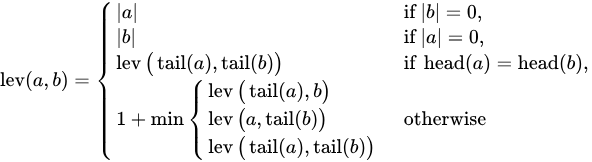

In [75]:
def levenshtein(a, b):
  if len(b) == 0:
    return len(a)
  if len(a) == 0:
    return len(b)

  if a[0] == b[0]:
    return levenshtein(a[1:], b[1:])

  return 1 + min(levenshtein(a[1:], b), levenshtein(a, b[1:]), levenshtein(a[1:], b[1:]))

levenshtein('abc', 'abc'), levenshtein('abc', 'ab'), levenshtein('ab', 'abc'), levenshtein('abc', 'abd')

(0, 1, 1, 1)

In [76]:
a = ''.join([chr2tri(c) for c in '안녕']), ''.join([chr2tri(c) for c in '아ㄴ녕'])
b = ''.join([chr2tri(c) for c in '안녕']), ''.join([chr2tri(c) for c in '가가녕'])
levenshtein(*a), levenshtein(*b)

(1, 5)